In [16]:
from mnist1d import plot_signals
from mnist1d.data import make_dataset, ObjectView


(40, 40)
(40,)
(40,)
[-5.1998907  -4.93322964 -4.66656858 -4.39990752 -4.13324646 -3.8665854
 -3.59992433 -3.33326327 -3.06660221 -2.79994115 -2.53328009 -2.26661902
 -1.99995796 -1.7332969  -1.46663584 -1.19997478 -0.93331372 -0.66665265
 -0.39999159 -0.13333053  0.13333053  0.39999159  0.66665265  0.93331372
  1.19997478  1.46663584  1.7332969   1.99995796  2.26661902  2.53328009
  2.79994115  3.06660221  3.33326327  3.59992433  3.8665854   4.13324646
  4.39990752  4.66656858  4.93322964  5.1998907 ]


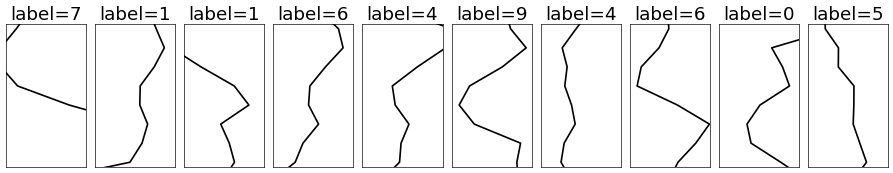

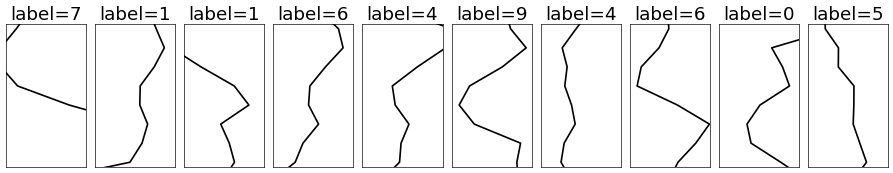

In [50]:
def visualize_mnist_1d(x, y, t, num=10):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(num, 1, figsize=(6,num*2))
    for i in range(num):
        axes[i].plot(t, x[i])
        axes[i].set_title(f'Label: {y[i]}')
    plt.tight_layout()
    plt.show()


dataset_args = ObjectView({
    'num_samples': 50,
    'train_split': 0.8,
    'template_len': 12,
    'padding': [36, 60],
    'scale_coeff': .4,
    'max_translation': 48,
    'corr_noise_scale': 0.25,
    'iid_noise_scale': 2e-2,
    'shear_scale': 0.75,
    'shuffle_seq': False,
    'final_seq_length': 40,
    'seed': 42,
})

data = make_dataset(dataset_args)

x, y, t = data['x'], data['y'], data['t']
print(x.shape)
print(y.shape)
print(t.shape)
print(t)

plot_signals(x[:20], t, labels=y[:20], ratio=2)